In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
import pandas as pd

In [0]:
fact_metro_pred = (spark.table("hive_metastore.tfm.fact_metro_ml"))

In [0]:
display(fact_metro_pred.limit(10))

date,total_ridership,awnd_bin,prcp_bin,snow_bin,snwd_bin,tmax_bin,tmin_bin,trange_bin,is_holiday,is_pre_holiday,is_weekend,day_of_week,month
2023-02-05,189.0,cat3,cat0,cat0,cat0,cat2,cat0,cat7,0,0,1,1,2
2023-02-05,5661.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,2576.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,1474.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,3206.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,3762.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,1110.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,650.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,4125.0,cat5,cat0,cat0,cat0,cat1,cat0,cat4,0,0,1,1,2
2023-02-05,2026.0,cat0,cat0,cat0,cat0,cat0,cat0,cat3,0,0,1,1,2


In [0]:
fact_metro_pred.count()

780446

# 1. TRATAMIENTO DE VALORES NULOS

In [0]:
null_counts = fact_metro_pred.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in fact_metro_pred.columns
])

null_counts.show()

+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|date|total_ridership|awnd_bin|prcp_bin|snow_bin|snwd_bin|tmax_bin|tmin_bin|trange_bin|is_holiday|is_pre_holiday|is_weekend|day_of_week|month|
+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|   0|              0|   10843|   10843|   10843|   10843|   10843|   10843|     10843|         0|             0|         0|          0|    0|
+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+



In [0]:
fact_metro_pred = (
    fact_metro_pred
    .where(F.col('awnd_bin').isNotNull())
)

In [0]:
null_counts = fact_metro_pred.select([
    F.count(F.when(F.col(c).isNull(), 1)).alias(c)
    for c in fact_metro_pred.columns
])

null_counts.show()

+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|date|total_ridership|awnd_bin|prcp_bin|snow_bin|snwd_bin|tmax_bin|tmin_bin|trange_bin|is_holiday|is_pre_holiday|is_weekend|day_of_week|month|
+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+
|   0|              0|       0|       0|       0|       0|       0|       0|         0|         0|             0|         0|          0|    0|
+----+---------------+--------+--------+--------+--------+--------+--------+----------+----------+--------------+----------+-----------+-----+



In [0]:
fact_metro_pred.count()

769603

# 2. TRATAMIENTO DE OUTLIERS

In [0]:
#Calculo de limites IQR
q1, q3 = fact_metro_pred.approxQuantile('total_ridership', [0.25, 0.75], 0.01)
iqr = q3 - q1

lower = q1 - (1.5 * iqr)
upper = q3 + (1.5 * iqr)

In [0]:
#Mostreo de datos para visualización
sample_pd = (
    fact_metro_pred
    .select('total_ridership')
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

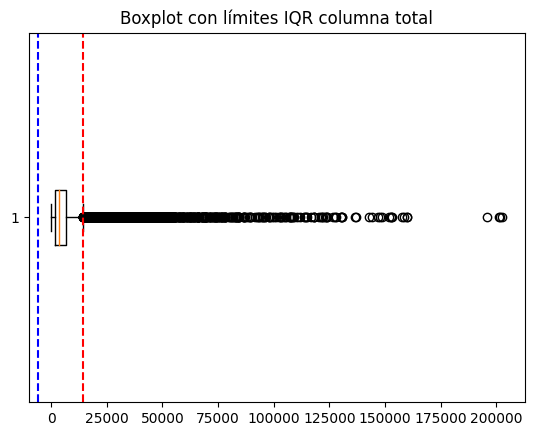

In [0]:
#Boxplot
plt.boxplot(sample_pd['total_ridership'], vert=False)
plt.axvline(lower, color='blue', linestyle='--')
plt.axvline(upper, color='red', linestyle='--')
plt.title('Boxplot con límites IQR columna total')
plt.show()

In [0]:
fact_metro_pred = (
    fact_metro_pred
        .withColumn(
        'total_log',
        F.log1p(F.col('total_ridership'))
    )
)

Recalculando datos con la nueva columna

In [0]:
#Calculo de limites IQR
q1_totallog, q3_totallog = fact_metro_pred.approxQuantile('total_log', [0.25, 0.75], 0.01)
iqr_totallog = q3_totallog - q1_totallog

lower_totallog = q1_totallog - (1.5 * iqr_totallog)
upper_totallog = q3_totallog + (1.5 * iqr_totallog)

In [0]:
#Mostreo de datos para visualización
sample_pd_totallog = (
    fact_metro_pred
    .select('total_log')
    .sample(fraction=0.05, seed=42)
    .toPandas()
)

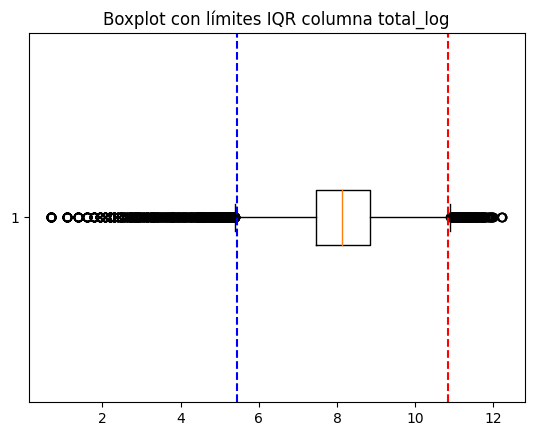

In [0]:
plt.boxplot(sample_pd_totallog['total_log'], vert=False)
plt.axvline(lower_totallog, color='blue', linestyle='--')
plt.axvline(upper_totallog, color='red', linestyle='--')
plt.title('Boxplot con límites IQR columna total_log')
plt.show()

## 3. ENTRENAMIENTO DEL MODELO

## 3.1 Partición train/validation/test

In [0]:
#2020
df20 = (
    fact_metro_pred
    .filter(F.year(F.col('date')) == 2020)
)

train_df20, val_df20, test_df20 = df20.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2021
df21 = (
    fact_metro_pred
    .filter(F.year(F.col('date')) == 2021)
)

train_df21, val_df21, test_df21 = df21.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2022
df22 = (
    fact_metro_pred
    .filter(F.year(F.col('date')) == 2022)
)

train_df22, val_df22, test_df22 = df22.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2023
df23 = (
    fact_metro_pred
    .filter(F.year(F.col('date')) == 2023)
)

train_df23, val_df23, test_df23 = df23.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

#2024
df24 = (
    fact_metro_pred
    .filter(F.year(F.col('date')) == 2024)
)

train_df24, val_df24, test_df24 = df24.randomSplit(
    [0.7, 0.15, 0.15],
    seed=42
)

In [0]:
train_df = (
    train_df20
    .union(train_df21)
    .union(train_df22)
    .union(train_df23)
    .union(train_df24)
)

val_df = (
    val_df20
    .union(val_df21)
    .union(val_df22)
    .union(val_df23)
    .union(val_df24)
)

test_df = (
    test_df20
    .union(test_df21)
    .union(test_df22)
    .union(test_df23)
    .union(test_df24)
)

In [0]:
train_df.cache()
val_df.cache()
test_df.cache()

train_df.count()
val_df.count()
test_df.count()

115891

## 3.2 Entrenamiento del modelo

In [0]:
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in [
        'awnd_bin', 'prcp_bin', 'snow_bin', 'snwd_bin',
        'tmax_bin', 'tmin_bin', 'trange_bin'
    ]
]

In [0]:
feature_cols = [
    'awnd_bin_idx', 'prcp_bin_idx', 'snow_bin_idx', 'snwd_bin_idx',
    'tmax_bin_idx', 'tmin_bin_idx', 'trange_bin_idx',
    'is_holiday', 'is_pre_holiday', 'is_weekend',
    'day_of_week', 'month'
]

In [0]:
assembler = VectorAssembler(
    inputCols = feature_cols,
    outputCol = 'features',
    handleInvalid = 'keep'
)

_**MODELO1: REGRESIÓN LINEAR**_

In [0]:
#Modelo Regresión Linear
label_col = 'total_log'

model = LinearRegression(
    featuresCol = 'features',
    labelCol = label_col
)

In [0]:
#Pipeline
pipeline = Pipeline(
    stages=indexers + [assembler, model]
)

In [0]:
#Train
model_fitted = pipeline.fit(train_df)

In [0]:
#Train + Val

pred_val = model_fitted.transform(val_df)

rmse_eval = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="rmse"
)

r2_eval = RegressionEvaluator(
    labelCol=label_col,
    predictionCol="prediction",
    metricName="r2"
)

rmse_val = rmse_eval.evaluate(pred_val)
r2_val = r2_eval.evaluate(pred_val)

rmse_val, r2_val

(1.1614947603333012, 0.1394183895817338)

_**MODELO2: RANDOM FOREST**_

In [0]:
#Modelo RF
label_col = 'total_log'

rf = RandomForestRegressor(
    labelCol=label_col,
    featuresCol="features",
    numTrees=100,
    maxDepth=8,
    seed=42
)

In [0]:
#Pipeline
pipeline_rf = Pipeline(
    stages=indexers + [assembler, rf]
)

In [0]:
#Train + val
rf_model = pipeline_rf.fit(train_df)

pred_val_rf = rf_model.transform(val_df)

rmse_rf = rmse_eval.evaluate(pred_val_rf)
r2_rf = r2_eval.evaluate(pred_val_rf)

rmse_rf, r2_rf

(1.1139350508800894, 0.20845193652176064)

## 3.3 Evaluación final en el conjunto de prueba

In [0]:
pred_test = rf_model.transform(test_df)

rmse_test = rmse_eval.evaluate(pred_test)
r2_test = r2_eval.evaluate(pred_test)

rmse_test, r2_test

(1.1193835574809679, 0.20597310520577172)

## 4 GUARDAR PREVISIONES

In [0]:
pred_to_save = (
    pred_test
    .withColumn(
        'prediction_exp',
        F.exp(F.col('prediction'))
    )
    .select(
        'date',
        F.col('prediction_exp').alias('prediction')
    )
)

display(pred_to_save.limit(10))

date,prediction
2020-01-01,1964.0660348143792
2020-01-01,2118.1426202812277
2020-01-01,2118.1426202812277
2020-01-01,1964.0660348143792
2020-01-01,2118.1426202812277
2020-01-01,2118.1426202812277
2020-01-01,1964.0660348143792
2020-01-01,1964.0660348143792
2020-01-01,2118.1426202812277
2020-01-01,2118.1426202812277


In [0]:
pred_to_save.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("tfm.metro_pred")

# 5. GRÁFICOS Y VISUALIZACIONES

In [0]:
df = fact_metro_pred
label_col = 'total_ridership'

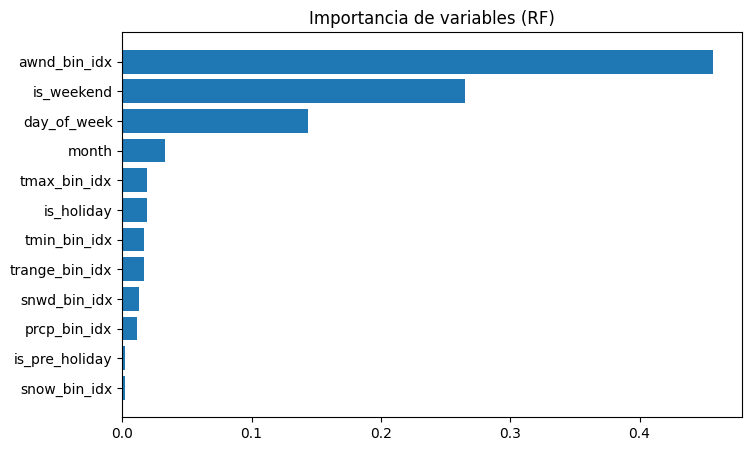

In [0]:
importances = rf_model.stages[-1].featureImportances

feature_names = feature_cols

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances.toArray()
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables (RF)')
plt.show()

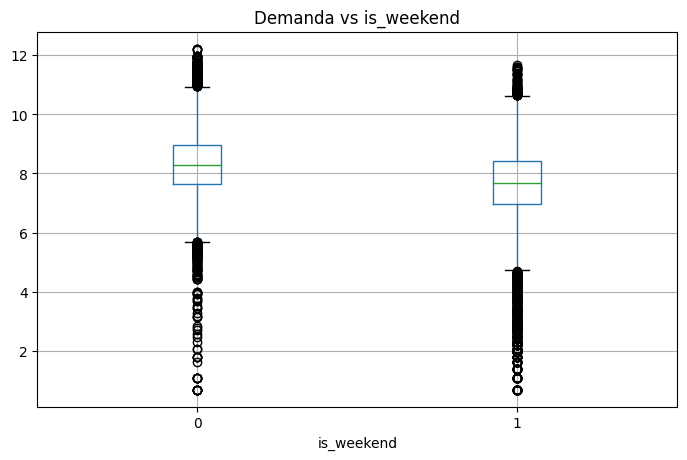

In [0]:
sample_pd = (
    fact_metro_pred.select("is_weekend", "total_log")
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(column="total_log", by="is_weekend", figsize=(8,5))
plt.title("Demanda vs is_weekend")
plt.suptitle("")
plt.show()

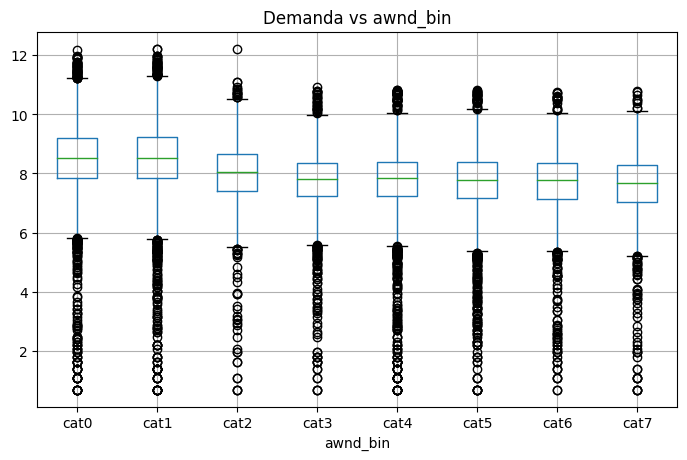

In [0]:
sample_pd = (
    fact_metro_pred.select("awnd_bin", "total_log")
      .sample(0.05, seed=42)
      .toPandas()
)

sample_pd.boxplot(column="total_log", by="awnd_bin", figsize=(8,5))
plt.title("Demanda vs awnd_bin")
plt.suptitle("")
plt.show()

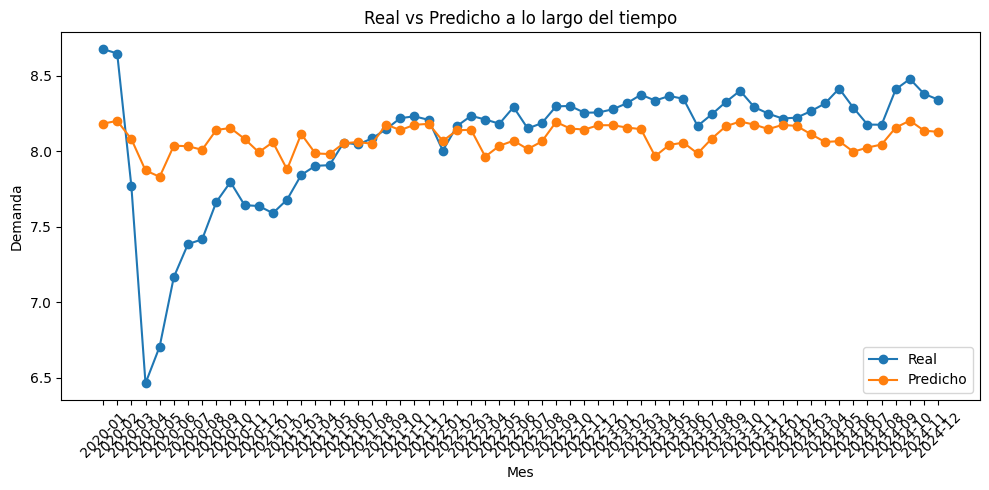

In [0]:
label_col = 'total_log'

pred_test = rf_model.transform(test_df)

ts_df = (
    pred_test
    .withColumn('year_month', F.date_format('date', 'yyyy-MM'))
    .groupBy('year_month')
    .agg(
        F.avg(label_col).alias('real'),
        F.avg('prediction').alias('pred')
    )
    .orderBy('year_month')
)

ts_pd = ts_df.toPandas()

plt.figure(figsize=(10,5))
plt.plot(ts_pd['year_month'], ts_pd['real'], label='Real', marker='o')
plt.plot(ts_pd['year_month'], ts_pd['pred'], label='Predicho', marker='o')
plt.xticks(rotation=45)
plt.title('Real vs Predicho a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Demanda')
plt.legend()
plt.tight_layout()
plt.show()